In [1]:
import geopandas as gpd
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from adjustText import adjust_text
from scipy.stats import kendalltau, pearsonr

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
gdf = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson")
gdf = gdf.rename(columns={"nom": "department"})
gdf.head()

,code,department,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ..."


In [3]:
country = "France"
year = 2022
location_level = "department"

colors = json.load(open("consts.json", encoding="utf-8"))

In [4]:
df = pd.read_csv(f"data_output/{country}/{year}_divisiveness_{location_level}.csv.gz", compression="gzip")
df = df.dropna()
df.head()

,department,candidate,value
0,Ain,Emmanuel MACRON,0.053806
1,Ain,Fabien ROUSSEL,0.012031
2,Ain,Jean LASSALLE,0.017987
3,Ain,Jean-Luc MÉLENCHON,0.059014
4,Ain,Marine LE PEN,0.065168


In [5]:
df_fround = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz", compression="gzip")
df_fround.columns = [x.lower() for x in df_fround.columns]

df_runoff = pd.read_csv(f"data_output/{country}/{year}_runoff.csv.gz", compression="gzip")
df_runoff.columns = [x.lower() for x in df_runoff.columns]

candidate_a, candidate_b = df_runoff.candidate.unique()
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip")

df_fround = pd.merge(df_fround, df_location, on="polling_id")
df_runoff = pd.merge(df_runoff, df_location, on="polling_id")

df_fround[location_level] = df_fround[location_level].replace({
    "BIOBIO": "BIO-BIO",
    "CHAÑARAL": "CHANARAL",
    "DEL TAMARUGAL": "TAMARUGAL",
    "SAN FELIPE DE ACONCAGUA": "SAN FELIPE"
})
df_runoff[location_level] = df_runoff[location_level].replace({
    "BIOBIO": "BIO-BIO",
    "CHAÑARAL": "CHANARAL",
    "DEL TAMARUGAL": "TAMARUGAL",
    "SAN FELIPE DE ACONCAGUA": "SAN FELIPE"
})

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

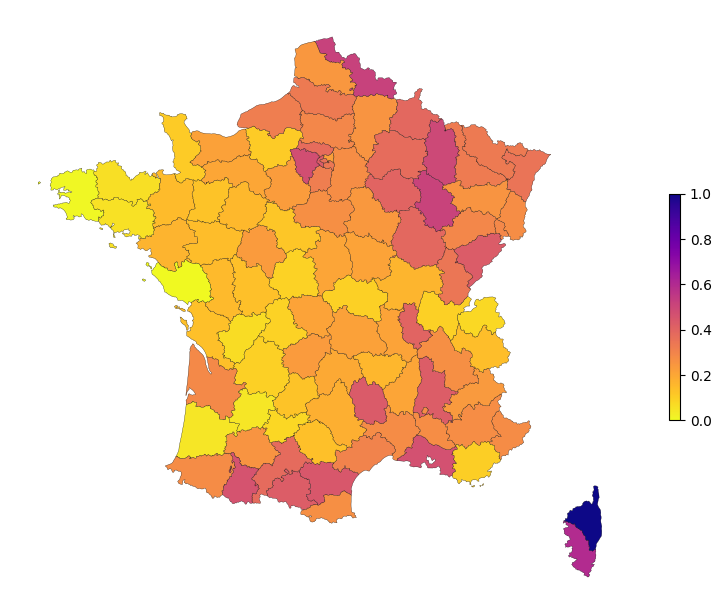

In [6]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = df.groupby(["department"]).agg({"value": "mean"}).reset_index()
data_tmp = pd.merge(data_tmp, gdf, on="department")

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="value", 
    edgecolor="black",
    cmap="plasma_r",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
        shrink=0.3
    )
)

plt.axis("off")

(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

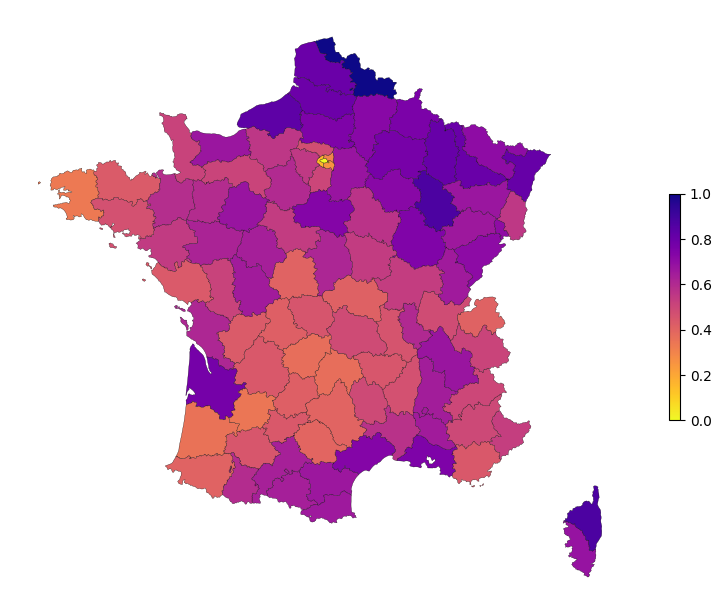

In [7]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = df[df["candidate"] == "Marine LE PEN"]
data_tmp = pd.merge(data_tmp, gdf, on="department")

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="value", 
    edgecolor="black",
    cmap="plasma_r",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
        shrink=0.3
    )
)

plt.axis("off")

In [8]:
df["rank"] = df.groupby("department")["value"].rank(ascending=False).astype(int)
df

,department,candidate,value,rank
0,Ain,Emmanuel MACRON,0.053806,3
1,Ain,Fabien ROUSSEL,0.012031,8
2,Ain,Jean LASSALLE,0.017987,7
3,Ain,Jean-Luc MÉLENCHON,0.059014,2
4,Ain,Marine LE PEN,0.065168,1
...,...,...,...,...
958,Yvelines,Marine LE PEN,0.071506,3
959,Yvelines,Nicolas DUPONT-AIGNAN,0.007639,9
960,Yvelines,Valérie PÉCRESSE,0.036441,5
961,Yvelines,Yannick JADOT,0.019890,6


In [9]:
colors

{'FRANCO PARISI FERNANDEZ': '#0D0066',
 'JOSE ANTONIO KAST RIST': '#22446d',
 'MARCO ENRIQUEZ-OMINAMI GUMUCIO': '#F429E3',
 'SEBASTIAN SICHEL RAMIREZ': '#E7DD14',
 'YASNA PROVOSTE CAMPILLAY': '#870C7C',
 'GABRIEL BORIC FONT': '#E71455',
 'Emmanuel MACRON': '#FFD600',
 'Fabien ROUSSEL': '#DD0000',
 'Jean LASSALLE': '#ADC1FD',
 'Jean-Luc MÉLENCHON': '#C9462C',
 'Marine LE PEN': '#004A77',
 'Nicolas DUPONT-AIGNAN': '#0087CD',
 'Valérie PÉCRESSE': '#0066CC',
 'Yannick JADOT': '#79b41d',
 'Éric ZEMMOUR': '#170066',
 'Anne HIDALGO': '#ED1651',
 'Corneliu Vadim Tudor': '#0258A4',
 'Crin Antonescu': '#FFDD00',
 'Hunor Kelemen': '#296633',
 'Mircea Geoană': '#ED2128',
 'Sorin Oprescu': '#DCDCDC',
 'Traian Băsescu': '#FF6633'}

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

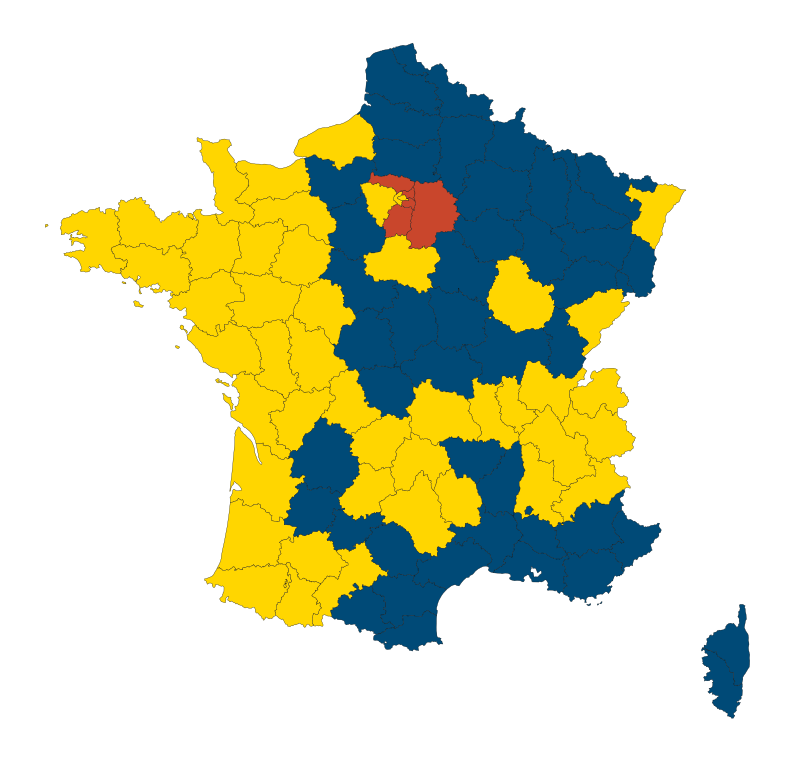

In [10]:
# df_fround["rank"] = df_fround.groupby([location_level, "candidate"]).agg({"value": "sum"}).groupby(level=0)["value"].rank(ascending=False).astype(int)
#df_fround.groupby(location_level)["value"].rank(ascending=False).astype(int)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
dd = df_fround.groupby([location_level, "candidate"]).agg({"value": "sum"})
dd["rank"] = dd.groupby(level=0)["value"].rank(ascending=False).astype(int)
dd = dd.reset_index()

data_tmp = dd[dd["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp["color"] = data_tmp["candidate"].replace(colors)

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="candidate",
    color=data_tmp["color"],
    edgecolor="black",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
#         shrink=0.3
    )
)

plt.axis("off")

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

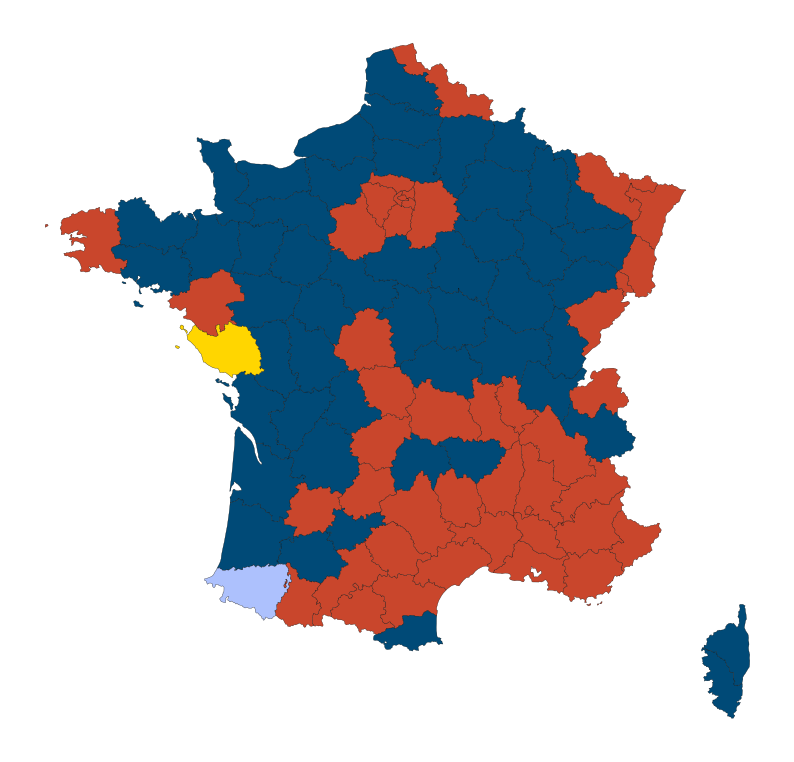

In [11]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = df[df["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on="department")
data_tmp["color"] = data_tmp["candidate"].replace(colors)
data_tmp = gpd.GeoDataFrame(data_tmp)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="candidate",
    color=data_tmp["color"],
    edgecolor="black",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
#         shrink=0.3
    )
)

plt.axis("off")

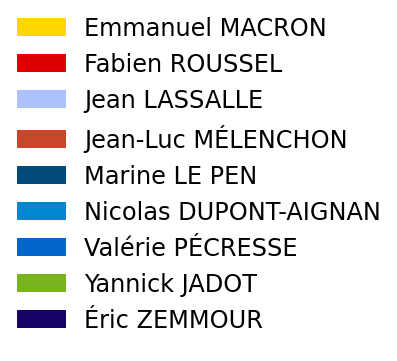

In [12]:
#Imports
import matplotlib.patches as mpatches

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

for key in colors.keys():
    if key in df["candidate"].unique():
        value = colors[key]
        patch = mpatches.Patch(color=value, label=key)
        handles.append(patch) 
        
legend = plt.legend(handles=handles, loc='lower center', fontsize=24, frameon=False, ncol=1)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.axis("off")
# export_legend(legend)
# plt.show()
legend

In [13]:
# ee = df[df["candidate"].isin(df_runoff.candidate.unique())]
# ee = ee.pivot(index=location_level, columns="candidate", values="value").reset_index()
# ee

In [14]:
endorsements = {
    "Emmanuel MACRON": [("Anne HIDALGO", "Yannick JADOT", "Valérie PÉCRESSE"), ("Jean-Luc MÉLENCHON", "Philippe POUTOU", "Fabien ROUSSEL")],
    "Marine LE PEN": [("Nicolas DUPONT-AIGNAN", "Éric ZEMMOUR"), ()]
}

aa = df_fround[df_fround["candidate"].isin(endorsements[candidate_a][0])].groupby("polling_id").agg({"rate": "sum"})
aa = aa.reset_index()
aa = aa.rename(columns={"rate": candidate_a})

bb = df_fround[df_fround["candidate"].isin(endorsements[candidate_b][0])].groupby("polling_id").agg({"rate": "sum"})
bb = bb.reset_index()
bb = bb.rename(columns={"rate": candidate_b})


df_endorsement = pd.merge(aa, bb, on="polling_id")
df_endorsement

,polling_id,Emmanuel MACRON,Marine LE PEN
0,Aast-0001,0.150000,0.092857
1,Abainville-0001,0.086207,0.126437
2,Abancourt-0001,0.338558,0.432602
3,Abaucourt-0001,0.047619,0.105820
4,Abaucourt-Hautecourt-0001,0.106061,0.136364
...,...,...,...
67189,Évian-les-Bains-0003,0.135575,0.123644
67190,Évian-les-Bains-0004,0.124088,0.132299
67191,Ô-de-Selle-0001,0.081511,0.097416
67192,Ô-de-Selle-0002,0.076923,0.038462


In [15]:
dd = pd.merge(df_fround, df_runoff, on=["polling_id", "candidate"])
dd = dd.pivot_table(index="polling_id", columns=["candidate"], values=["rate_x", "rate_y"])
dd = dd.reset_index()
dd.columns = [f"{a}{b}" for a, b in dd.columns]

dd["winner"] = dd.apply(lambda x: \
                        candidate_a if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else candidate_b, axis=1)
dd["loser"] = dd.apply(lambda x: \
                        candidate_a if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else candidate_b, axis=1)

dd["rate_winner"] = dd.apply(lambda x: \
                        x[f"rate_x{candidate_a}"] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[f"rate_x{candidate_b}"], axis=1)
dd["rate_loser"] = dd.apply(lambda x: \
                        x[f"rate_x{candidate_a}"] if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else x[f"rate_x{candidate_b}"], axis=1)

dd = pd.merge(dd, df_location, on="polling_id")

dd = pd.merge(dd, df[["value", "candidate", location_level]].rename(columns={"value": "dv_winner"}), 
              left_on=[location_level, "winner"], right_on=[location_level, "candidate"])
dd = pd.merge(dd, df.rename(columns={"value": "dv_loser"}), 
    left_on=[location_level, "loser"], right_on=[location_level, "candidate"])

dd = pd.merge(dd, df_endorsement, on="polling_id")

dd["en_winner"] = dd.apply(lambda x: \
                        x[candidate_a] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[candidate_b], axis=1)
dd["en_loser"] = dd.apply(lambda x: \
                        x[candidate_b] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[candidate_a], axis=1)


dd["flip"] = ((dd[f"rate_x{candidate_a}"] > dd[f"rate_x{candidate_b}"]) & (dd[f"rate_y{candidate_a}"] < dd[f"rate_y{candidate_b}"])) |\
    ((dd[f"rate_x{candidate_b}"] > dd[f"rate_x{candidate_a}"]) & (dd[f"rate_y{candidate_b}"] < dd[f"rate_y{candidate_a}"]))

# dd = pd.merge(dd, ee, on=[location_level])
dd["flip"] = dd["flip"].astype(int)
dd.to_csv("test.csv", index=False)

<AxesSubplot:xlabel='Divisiveness (%) Winner', ylabel='Divisiveness (%) Loser'>

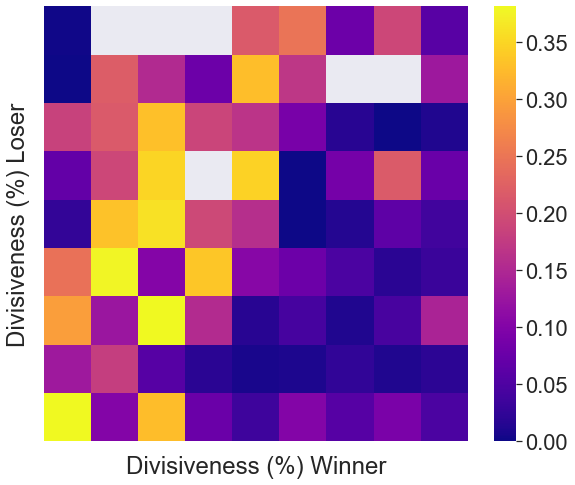

In [16]:
df_test = dd.copy()
df_test["qdv_winner"] = pd.qcut(df_test["dv_winner"], 9).astype(str)
df_test["qdv_loser"] = pd.qcut(df_test["dv_loser"], 9).astype(str)
m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(9.5, 8))
g = sns.heatmap(m, cmap="plasma")
g.invert_yaxis()
g.set_xlabel("Divisiveness (%) Winner")
g.set_ylabel("Divisiveness (%) Loser")
g.set_xticklabels([])
g.set_yticklabels([])
g

<AxesSubplot:xlabel='Rate (%) Winner', ylabel='Rate (%) Loser'>

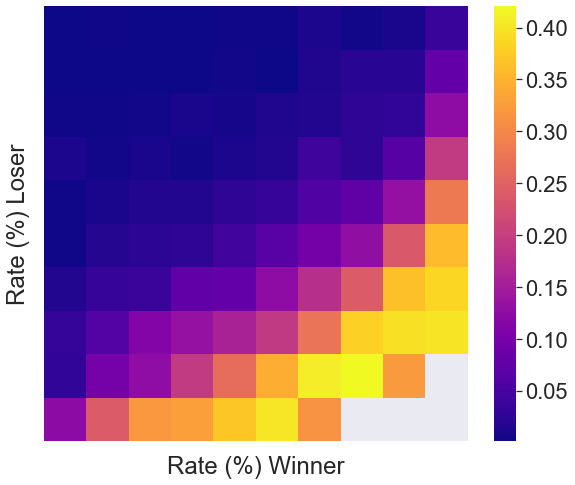

In [17]:
df_test = dd.copy().dropna()
df_test["qdv_winner"] = pd.qcut(df_test["rate_winner"], 10).astype(str)
df_test["qdv_loser"] = pd.qcut(df_test["rate_loser"], 10).astype(str)
m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(9.5, 8))
g = sns.heatmap(m, cmap="plasma")
g.invert_yaxis()
g.set_xlabel("Rate (%) Winner")
g.set_ylabel("Rate (%) Loser")
g.set_xticklabels([])
g.set_yticklabels([])
g

In [18]:
df_poverty = pd.read_excel("data_external/France/poverty_2017.xlsx", sheet_name="Figure 3", header=2).dropna()
df_poverty["Taux de pauvreté"] = df_poverty["Taux de pauvreté"].astype(float) / 100
df_poverty = df_poverty.rename(columns={"Code": "geo_id", "Département": "department", "Taux de pauvreté": "poverty_rate"})
df_poverty.head()

,geo_id,department,poverty_rate
0,74,Haute-Savoie,0.091
1,85,Vendée,0.093
2,78,Yvelines,0.094
3,73,Savoie,0.098
4,44,Loire-Atlantique,0.101


In [19]:
overseas = ["Guadeloupe", "Martinique", "Guyane", "La Réunion", "Mayotte"]


In [20]:
df_location[["department", "department_id"]].drop_duplicates()

,department,department_id
0,Ain,01
584,Aisne,02
1558,Allier,03
2010,Alpes-de-Haute-Provence,04
2273,Hautes-Alpes,05
...,...,...
69191,Polynésie française,ZP
69441,Saint-Pierre-et-Miquelon,ZS
69445,Wallis et Futuna,ZW
69446,Saint-Martin/Saint-Barthélemy,ZX


In [21]:
# data.head(50)

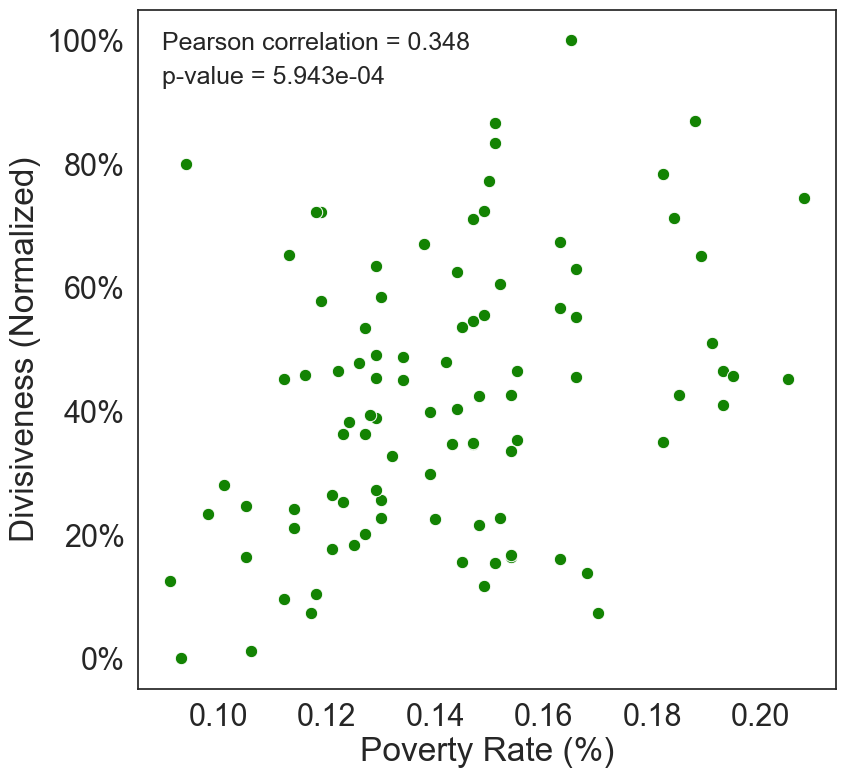

In [22]:
df_tmp = df.groupby("department").agg({"value": "mean"}).reset_index()
data = pd.merge(df_tmp, df_poverty, on="department")
data = data[~data["department"].isin(overseas)]
data = pd.merge(data, df_location[["department", "department_id"]].drop_duplicates(), on="department")
data = data[~data["department_id"].isin(["2B", "93"])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data["value"] = NormalizeData(data["value"])

sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(9, 9), dpi=100)

x = "poverty_rate"
y = "value"

corr, _ = pearsonr(data[x], data[y])
p_value = "{:0.3e}".format(_)

# plt.legend([], [], loc=2, title=f"R²={(corr*corr*100).round(1)}%\np-value={p_value}", frameon=False)
FONT_SIZE = 18
ax.text(
    0.035, 0.95, 
           f"Pearson correlation = {(corr).round(3)}", ha="left", va="center", fontsize=FONT_SIZE, 
           transform=ax.transAxes)
ax.text(0.035, 0.9, 
       f"p-value = {p_value}", ha="left", va="center", fontsize=FONT_SIZE, 
       transform=ax.transAxes)

sns.scatterplot(x="poverty_rate", s=80, lw=0, y="value", data=data, ax=ax, color="#138303")

ax.set_xlabel("Poverty Rate (%)")
ax.set_ylabel("Divisiveness (Normalized)")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# texts = []
# for x, tmp in data.iterrows():
#     texts.append(ax.text(tmp["poverty_rate"], tmp["value"], tmp["department_id"], fontsize=16, color="#444444"))
    
# adjust_text(texts, lim=200, ax=ax, arrowprops=dict(arrowstyle="-", color="#766596")) 

In [23]:
df_voters = df_location.groupby("department").agg({"electors": "sum", "abstentions": "sum"}).reset_index()

df_part_fround = df_voters.copy()
df_part_fround["abstention"] = (df_part_fround["abstentions"] / df_part_fround["electors"])


In [24]:
data.sort_values("department_id").tail(50)

,department,value,geo_id,poverty_rate,department_id
55,Loiret,0.449991,45,0.134,45
56,Lot,0.215841,46,0.148,46
57,Lot-et-Garonne,0.072526,47,0.170,47
58,Lozère,0.723285,48,0.149,48
59,Maine-et-Loire,0.241703,49,0.114,49
60,Manche,0.177377,50,0.121,50
61,Marne,0.625081,51,0.144,51
38,Haute-Marne,0.865953,52,0.151,52
62,Mayenne,0.210431,53,0.114,53
63,Meurthe-et-Moselle,0.546089,54,0.147,54


200

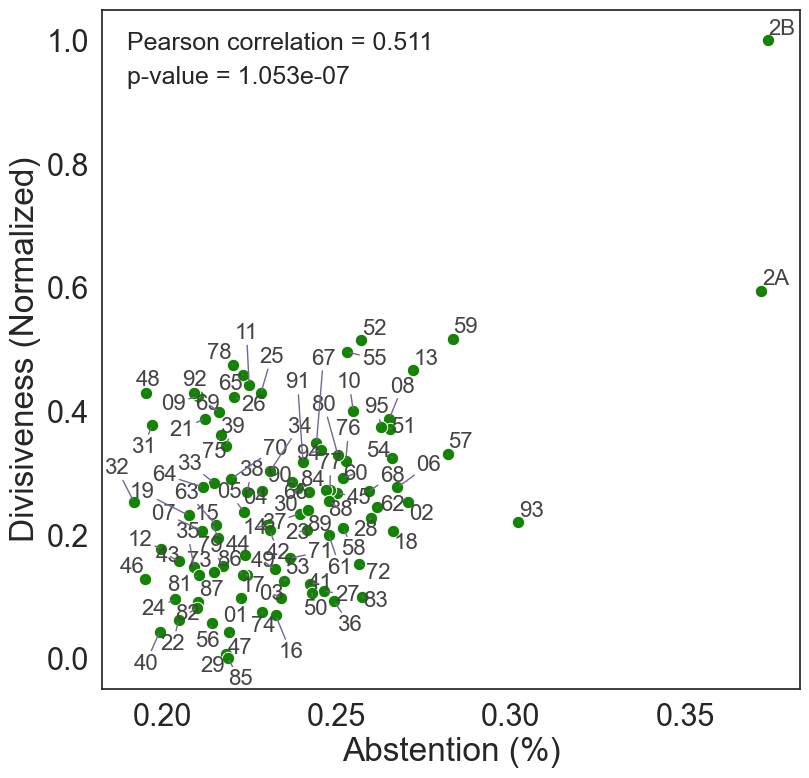

In [25]:
df_tmp = df.groupby("department").agg({"value": "mean"}).reset_index()
data = pd.merge(df_tmp, df_part_fround[["department", "abstention"]], on="department")
data = data[~data["department"].isin(overseas)]
data = pd.merge(data, df_location[["department", "department_id"]].drop_duplicates(), on="department")
data = data[~data["department_id"].isin(["ZZ", "ZX", "ZS", "ZP", "ZN"])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data["value"] = NormalizeData(data["value"])

sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(9, 9), dpi=100)

x = "abstention"
y = "value"

corr, _ = pearsonr(data[x], data[y])
p_value = "{:0.3e}".format(_)

# plt.legend([], [], loc=2, title=f"R²={(corr*corr*100).round(1)}%\np-value={p_value}", frameon=False)
FONT_SIZE = 18
ax.text(
    0.035, 0.95, 
           f"Pearson correlation = {(corr).round(3)}", ha="left", va="center", fontsize=FONT_SIZE, 
           transform=ax.transAxes)
ax.text(0.035, 0.9, 
       f"p-value = {p_value}", ha="left", va="center", fontsize=FONT_SIZE, 
       transform=ax.transAxes)

sns.scatterplot(x=x, s=80, lw=0, y=y, data=data, ax=ax, color="#138303")

ax.set_xlabel("Abstention (%)")
ax.set_ylabel("Divisiveness (Normalized)")

# ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

texts = []
for idx, tmp in data.iterrows():
    texts.append(ax.text(tmp[x], tmp[y], tmp["department_id"], fontsize=16, color="#444444"))
    
adjust_text(texts, lim=200, ax=ax, arrowprops=dict(arrowstyle="-", color="#766596")) 

In [33]:
aa = df_runoff.groupby([location_level, "candidate"]).agg({"value": "sum"})
aa["rate"] = aa.groupby(level=[0]).apply(lambda x: x/x.sum())
aa = aa.reset_index()
aa = aa.pivot(index=location_level, columns="candidate", values="rate").reset_index()
aa["diff"] = aa[candidate_a] - aa[candidate_b]
aa

candidate,department,Emmanuel MACRON,Marine LE PEN,diff
0,Ain,0.546995,0.453005,0.093990
1,Aisne,0.421548,0.578452,-0.156904
2,Allier,0.523152,0.476848,0.046304
3,Alpes-Maritimes,0.501156,0.498844,0.002312
4,Alpes-de-Haute-Provence,0.500870,0.499130,0.001739
...,...,...,...,...
102,Vienne,0.589362,0.410638,0.178725
103,Vosges,0.479947,0.520053,-0.040106
104,Wallis et Futuna,0.674472,0.325528,0.348944
105,Yonne,0.491956,0.508044,-0.016087


In [36]:
bb = df.groupby(location_level).agg({"value": "mean"}).reset_index()
bb

,department,value
0,Ain,0.030982
1,Aisne,0.037166
2,Allier,0.030995
3,Alpes-Maritimes,0.038077
4,Alpes-de-Haute-Provence,0.037870
...,...,...
101,Vendée,0.027138
102,Vienne,0.032443
103,Vosges,0.037183
104,Yonne,0.036637


In [47]:
cc = pd.merge(aa, bb, on=location_level)
cc = cc[~cc["department"].isin(overseas)]

cc["diff_abs"] = np.abs(cc["diff"])
cc["winner"] = cc.apply(lambda x: candidate_a if x[candidate_a] > x[candidate_b] else candidate_b, axis=1)

In [48]:
cc.corr()

,Emmanuel MACRON,Marine LE PEN,diff,value,diff_abs
Emmanuel MACRON,1.000000,-1.000000,1.000000,-0.026560,0.885626
Marine LE PEN,-1.000000,1.000000,-1.000000,0.026560,-0.885626
diff,1.000000,-1.000000,1.000000,-0.026560,0.885626
value,-0.026560,0.026560,-0.026560,1.000000,0.124829
diff_abs,0.885626,-0.885626,0.885626,0.124829,1.000000


Text(0, 0.5, 'Diff Candidates')

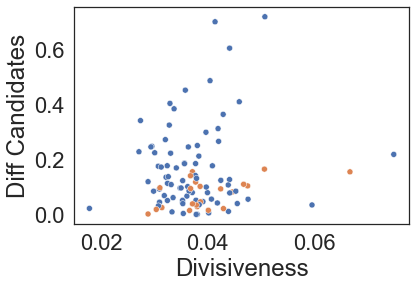

In [50]:
g = sns.scatterplot(x="value", y="diff_abs", hue="winner", legend=False, data=cc)
g.set_xlabel("Divisiveness")
g.set_ylabel("Diff Candidates")